# ImmoEliza - Data Modelling

This notebook explores the different data models and how data selection and scaling impacts the predicted price. 

If you want to rerun the model for a different property type (see below), you will need to import the dataframe again.

**Caveats:**
* At the moment this model only includes numerical variables (such as number of bedrooms or area of the plot) not categorical variables (such as building condition, heating type or EPC). 
* The model does not use any form of scaling.

In [1]:
#import libraries 
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [2]:
#import dataframe and display first rows and the total number of columns and rows
df = pd.read_csv('../data/saved_data.csv', index_col=0)
display(df.head())
df.shape

,property_type,property_subtype,immo_code,location,postcode,province,region,price,address,energy_class,...,construction_year,building_condition,bedrooms,bathrooms,shower_rooms,office,toilets,kitchen_type,heating_type,price_orig
0,house,house,10666428,essen,2910,Antwerpen,Flanders,469000,Heidestatiestraat 26,D,...,0,0,3,1,0,0,2,Installed,0,€469000
1,house,house,10666426,bierges,1301,Brabant wallon,Wallonia,1395000,"Rue de Wavre, 27",C,...,1988,Good,5,2,3,1,4,Hyper equipped,Fuel oil,€1395000
2,apartment,apartment,10666424,arlon,6700,Luxembourg,Wallonia,285000,Avenue de Longwy 340,D,...,0,Good,2,2,0,0,2,Installed,Electric,€285000
3,house,house,10666423,arlon,6700,Luxembourg,Wallonia,285000,Avenue de Longwy 340,D,...,0,Good,2,2,0,0,2,Installed,Electric,€285000
4,apartment,apartment,10666422,antwerp,2000,Antwerpen,Flanders,425000,"Grote steenweg, 511",C,...,0,As new,2,1,0,0,0,Installed,0,€425000


(6545, 27)

### Select properties by (sub)type
You can hardly compare a kot to a castle. Therefore you can run the model for different property (sub)types. This model is limited to housing types so commercial and industrial buildings are excluded. It uses the types and subtypes set by Immoweb. There are two main types, 'house' and 'apartment' with the following subtypes: 

* house: house, villa, mixed-use-building, exceptional-property, other-property, country-cottage, mansion, town-house, bungalow, farmhouse, new-real-estate-project-houses, chalet, manor-house, castle
* apartment: apartment, service-flat, duplex, triplex, apartment-block, loft, ground-floor, new-real-estate-project-apartments, kot, penthouse, flat-studio

By changing the codeblock below, you can select which (sub)types you want to include (==) or exclude (!=). By default castles are excluded from the model. If you want to change this selection, you should start by reloading the original data by rerunning the codeblock above.

In [3]:

#df = df[df.property_type == 'apartment']
df = df[df.property_type == 'house']
df = df[df.property_subtype != 'castle'] #by default we exclude castles from our model 

In [4]:
print(df.shape)
display(df.head())

(4191, 27)


,property_type,property_subtype,immo_code,location,postcode,province,region,price,address,energy_class,...,construction_year,building_condition,bedrooms,bathrooms,shower_rooms,office,toilets,kitchen_type,heating_type,price_orig
0,house,house,10666428,essen,2910,Antwerpen,Flanders,469000,Heidestatiestraat 26,D,...,0,0,3,1,0,0,2,Installed,0,€469000
1,house,house,10666426,bierges,1301,Brabant wallon,Wallonia,1395000,"Rue de Wavre, 27",C,...,1988,Good,5,2,3,1,4,Hyper equipped,Fuel oil,€1395000
3,house,house,10666423,arlon,6700,Luxembourg,Wallonia,285000,Avenue de Longwy 340,D,...,0,Good,2,2,0,0,2,Installed,Electric,€285000
6,house,house,10666419,grace-hollogne,4460,Liï¿½ge,Wallonia,189000,Avenue Louis Libert 1,E,...,1934,Good,2,1,0,0,0,Semi equipped,Fuel oil,€189000
7,house,villa,10666418,aywaille,4920,Liï¿½ge,Wallonia,399999,Avenue Louis Libert 1,C,...,2004,To be done up,4,1,0,1,0,Semi equipped,Fuel oil,€399999


### Define model variables


In [5]:
#int_columns=['furnished', 'terrace', 'terrace_surface', 'plot_surface', 'living_room_surface', 'frontages', 'construction_year', 'bedrooms', 'bathrooms', 'shower_rooms', 'office', 'toilets']
int_columns=['primary_energy_consumption', 'furnished', 'terrace', 'terrace_surface', 'plot_surface', 'living_room_surface', 'frontages', 'construction_year', 'bedrooms', 'bathrooms', 'shower_rooms', 'office', 'toilets']
#int_columns=['bedrooms', 'bathrooms', 'toilets']

X = df[int_columns].to_numpy()
y = df.price.to_numpy().reshape(-1,1)
print(type(X))
print(X)


<class 'numpy.ndarray'>
[[390   0   1 ...   0   0   2]
 [178   0   1 ...   3   1   4]
 [299   0   0 ...   0   0   2]
 ...
 [199   0   1 ...   0   0   3]
 [161   0   1 ...   0   0   0]
 [197   0   1 ...   3   1   4]]


### Some graphs

In [6]:
# create a dataframe which (only) combines X & y to create some graphs
cropped_df = df.loc[:,int_columns]
cropped_df["price"] = df["price"]
cropped_df.head()

,primary_energy_consumption,furnished,terrace,terrace_surface,plot_surface,living_room_surface,frontages,construction_year,bedrooms,bathrooms,shower_rooms,office,toilets,price
0,390,0,1,0,760,34,4,0,3,1,0,0,2,469000
1,178,0,1,60,6468,50,4,1988,5,2,3,1,4,1395000
3,299,0,0,0,0,0,2,0,2,2,0,0,2,285000
6,346,0,1,0,360,32,2,1934,2,1,0,0,0,189000
7,228,0,1,0,1059,44,4,2004,4,1,0,1,0,399999


In [7]:
"""Create pairplots (versus Price) and display dataframe"""

"""display(cropped_df.sample(10))
sns.pairplot(data=df, y_vars = "Price", x_vars = int_columns, height=5)
sns.pairplot(data=cropped_df)"""

'display(cropped_df.sample(10))\nsns.pairplot(data=df, y_vars = "Price", x_vars = int_columns, height=5)\nsns.pairplot(data=cropped_df)'

<function matplotlib.pyplot.show(close=None, block=None)>

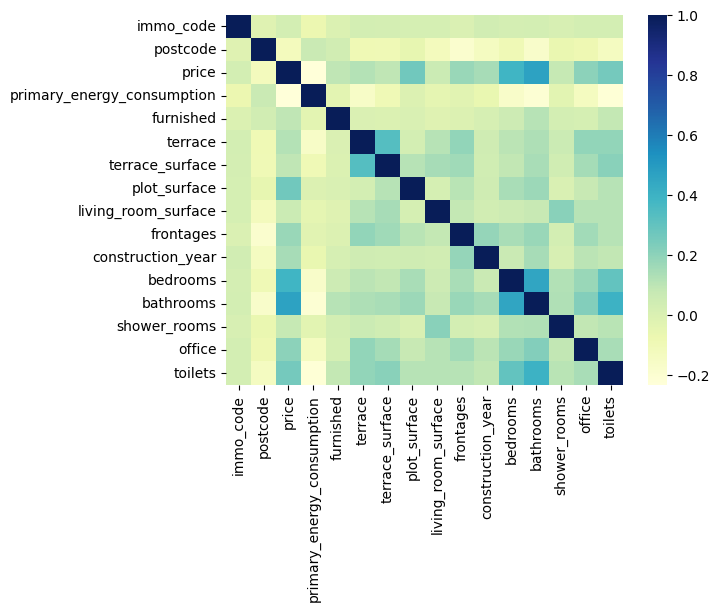

In [8]:
"""Create heatmaps for full dataframe and selected columns"""

sns.heatmap(df.select_dtypes(include="number").corr(), cmap="YlGnBu", annot=False) #heatmap of all numerical columns in dataframe
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

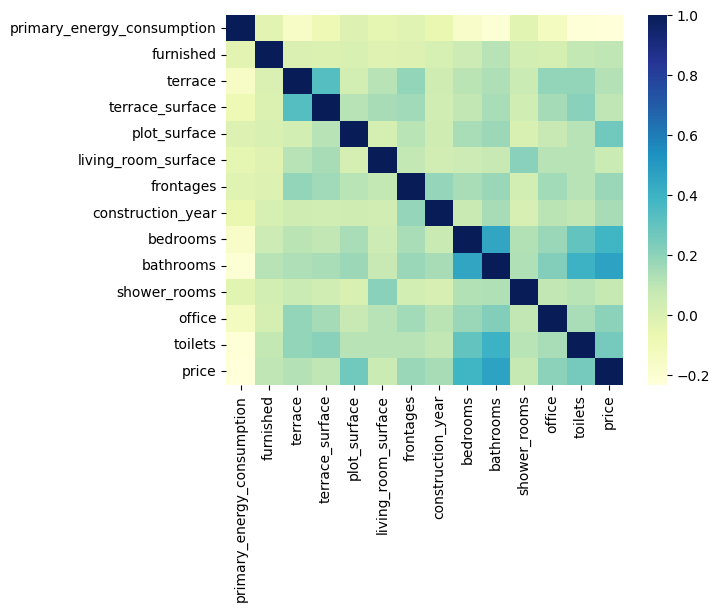

In [9]:
sns.heatmap(cropped_df.corr(), cmap="YlGnBu", annot=False) #heatmap of selected columns
plt.show

### Split the dataset

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=41)

In [11]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (3352, 13)
Shape of X_test:  (839, 13)
Shape of y_train:  (3352, 1)
Shape of y_test:  (839, 1)


##  Load and fit the model (with Sklearn)

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [13]:
from sklearn.linear_model import LinearRegression

LR_model = "Linear Regression"

LR_regressor = LinearRegression()
"""X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)"""
LR_regressor.fit(X_train, y_train)
LR_train_score = LR_regressor.score(X_train, y_train)
LR_test_score = LR_regressor.score(X_test,y_test)
LR_y_pred = LR_regressor.predict(X_test)
LR_R_MSE = mean_squared_error(y_test, LR_y_pred, squared = False)

In [14]:
from sklearn.tree import DecisionTreeRegressor

DT_model = "Decision Tree"

DT_regressor = DecisionTreeRegressor(max_depth=6, min_weight_fraction_leaf=0.01)

DT_regressor.fit(X_train, y_train)
DT_train_score = DT_regressor.score(X_train, y_train)
DT_test_score = DT_regressor.score(X_test,y_test)
DT_y_pred = DT_regressor.predict(X_test)
DT_R_MSE = mean_squared_error(y_test, DT_y_pred, squared = False)

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

GS_model = "Decision Tree with GridSearch"

params = {"max_depth" : [2, 4, 6, 8, 10, 12], "min_weight_fraction_leaf" : [0.002, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.006, 0.01]}
grid_search = GridSearchCV(DT_regressor, params, cv = 10)
grid_search.fit(X_train,y_train)
best_params = grid_search.best_params_
print(best_params)
GS_regressor = DecisionTreeRegressor(max_depth=best_params["max_depth"], min_weight_fraction_leaf=best_params["min_weight_fraction_leaf"])
GS_regressor.fit(X_train, y_train)
GS_train_score = GS_regressor.score(X_train, y_train)
GS_test_score = GS_regressor.score(X_test,y_test)
GS_y_pred = GS_regressor.predict(X_test)
GS_R_MSE = mean_squared_error(y_test, GS_y_pred, squared = False)

{'max_depth': 10, 'min_weight_fraction_leaf': 0.005}


In [16]:
import xgboost as xg

XG_model = "XG Boost"

XG_regressor = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 20)
"""X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)"""
XG_regressor.fit(X_train, y_train)
XG_train_score = XG_regressor.score(X_train, y_train)
XG_test_score = XG_regressor.score(X_test,y_test)
XG_y_pred = XG_regressor.predict(X_test)
XG_R_MSE = mean_squared_error(y_test, XG_y_pred, squared = False)

[10:57:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


### Scores

"Create a dataframe with an overview of the test scores of all the models"

model_list = ["LR", "DT", "GS", "XG"]
model_score_list = ["model", "train_score", "test_score", "R_MSE"]
data = []
for model in model_list:
    #print(model)
    modelscores = []
    for score in model_score_list:
        item = model + "_" + score
        modelscores.append(item)
    #print(modelscores)
    #modelscores = list(re.replace(r"/['"]+/g", '', str(modelscores)))
    #print(print(modelscores))
    data.append(modelscores)

print(data)
score_df = pd.DataFrame(data, columns=model_score_list)
score_df


In [17]:
model_score_list = ["model", "train_score", "test_score", "R_MSE"]
#display(score_df)
#score_df["train_score_old"] = score_df["train_score"]
#score_df["test_score_old"] = score_df["test_score"]
#score_df["R_MSE_old"] = score_df["R_MSE"]

data = [[LR_model, LR_train_score, LR_test_score, LR_R_MSE], [DT_model, DT_train_score, DT_test_score, DT_R_MSE], [GS_model, GS_train_score, GS_test_score, GS_R_MSE], [XG_model, XG_train_score, XG_test_score, XG_R_MSE]]
newscore_df = pd.DataFrame(data, columns=model_score_list)
#score_df = score_df.join(newscore_df, on=['model'], how='right')
#score_df ["train_score", "test_score", "R_MSE"] = newscore_df ["train_score", "test_score", "R_MSE"]
score_df=newscore_df
display(score_df)

,model,train_score,test_score,R_MSE
0,Linear Regression,0.332542,0.241081,412860.330671
1,Decision Tree,0.496685,0.488285,339015.472697
2,Decision Tree with GridSearch,0.555839,0.530611,324692.242729
3,XG Boost,0.855712,0.702592,258453.228511
